In [9]:
%load_ext autoreload
%autoreload 2

import equinox as eqx
from jax.random import PRNGKey, split
import src.InferenceModel as Infer
from src.utils.miscellaneous import dict_to_namedtuple
from src.utils.trace_dataset import load_traces
from pathlib import Path
from experiments.bayes3d.bayes3d import SceneSampler
from numpyro.handlers import trace, substitute

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
means_and_stds = load_traces("tmp/500k_bayes3d_mean_and_std.pkl")
means_and_stds = dict_to_namedtuple(means_and_stds)

c = Infer.InferenceModelCfg(
    means_and_stds = means_and_stds,
    d_model = 128,
    dropout_rate = 0.1,
    discrete_mlp_width = 512,
    discrete_mlp_depth=1,
    continuous_flow_blocks=8,
    continuous_flow_num_layers_per_block=2,
    continuous_flow_num_augment=91,
    num_enc_layers=5,
    max_discrete_choices =6,
    num_input_variables = (225,1),
    num_observations =100,
)

inference = Infer.InferenceModel(key=PRNGKey(0),c=c)

In [3]:
inference = eqx.tree_deserialise_leaves("tmp/500k_bayes3d_best.eqx", inference)
inference = eqx.tree_inference(inference, True)

In [6]:
sampler_ = SceneSampler(
                        # mesh_paths=[Path("sample_objs/bunny.obj")],
                        mesh_paths=[Path("ycb_video_models/models/025_mug/textured_simple.obj")],
                        num_objects=1,
                        max_pose_xy_noise=0.3,
                        )
seed = PRNGKey(5378596782395720)
tr = trace(sampler_).get_trace(key=seed)
img, flattened_patches, obs = sampler_(key=seed)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (160, 160, 512)


OrderedDict([('num_objects',
              {'type': 'sample',
               'name': 'num_objects',
               'fn': <numpyro.distributions.discrete.CategoricalProbs at 0x7f80182cc730>,
               'args': (),
               'kwargs': {'rng_key': Array([409091309, 734033673], dtype=uint32),
                'sample_shape': ()},
               'value': Array(0, dtype=int32),
               'scale': None,
               'is_observed': False,
               'intermediates': [],
               'cond_indep_stack': [],
               'infer': {}}),
             ('type_of_object_0',
              {'type': 'sample',
               'name': 'type_of_object_0',
               'fn': <numpyro.distributions.discrete.CategoricalProbs at 0x7f7e1c0ad550>,
               'args': (),
               'kwargs': {'rng_key': Array([2411918098, 1804235374], dtype=uint32),
                'sample_shape': ()},
               'value': Array(0, dtype=int32),
               'scale': None,
               'is_o

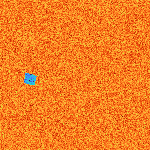

In [7]:
import bayes3d as j

gt_img = sampler_.reconsctruct_from_patches(obs, (150,150), 15)
gt_img = j.viz.get_depth_image(gt_img)
gt_img

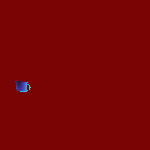

In [14]:
sampled_variables, trace_ = inference.rsample(obs, sampler_, PRNGKey(567))
model_pred = substitute(sampler_, sampled_variables)
img_, flattened_patches_, obs_ = model_pred(PRNGKey(5668499))
pred_img = sampler_.reconsctruct_from_patches(flattened_patches_, (150,150), 15)
pred_img = j.viz.get_depth_image(pred_img)
pred_img